In [5]:
import datetime as datetime
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.display import Image
plt.style.use('default') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (15, 5)
from pyspark import SparkContext
from pyspark import SparkConf
import pyspark as ps

try: 
    type(sc)
except NameError:
    sc = ps.SparkContext('local[*]')

In [6]:
from pandas import Series
avisos = pd.read_csv("Sources/fiuba_5_avisos_online.csv")
descripcion = pd.read_csv("Sources/fiuba_6_avisos_detalle.csv")
completo = pd.merge(avisos,descripcion, how = 'inner')
completo.head(2)

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,1112355872,1,Recepcionista/Asistente Administrativa,"<p><span lang=""ES"">RE/MAX Liberty, e</span>mpr...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Recepcionista,Remax
1,1112335374,1,Chofer /Operario de deposito con C.N.R.T. (EXC...,<p><strong>Empresa importadora de insumos de i...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Producción,G&G Argentina S.A.


In [7]:
completo['descripcion'] = completo.apply(lambda x: str.upper(re.sub("<.*?>", "", x['descripcion'])),axis=1)
completo['descripcion'] = completo.apply(lambda x: re.sub("\xa0", "", x['descripcion']),axis=1)
des = completo['descripcion'].tolist()

In [8]:
for x in des:
    x = tuple(x)

In [9]:
des = sc.parallelize(des)
des

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:175

In [10]:
import re, string, unicodedata
def removePunctuation(text):    
    text=str(text).lower().strip(' ')
    text=unicodedata.normalize('NFD', text).encode('ascii','ignore')
    text=text.decode('utf-8')
    text=re.sub(r'[^a-zA-Z0-9 ]', '', text)   
    return text

des = des.map(removePunctuation)

In [11]:
stopwords = ['el', 'la', 'los', 'les', 'las', 'de', 'del', 'a', 'ante', 'con', 'en', 'para', 'por', 'y', 'o', 'u', 'tu', 'te', 'ti', 'le', 'que', 'al', 'ha', 'un', 'han', 'lo', 'su', 'una', 'e','estas', 'esto', 'este', 'es', 'tras', 'suya', 'a', 'acá', 'ahí', 'ajena', 'ajenas', 'ajeno', 'ajenos', 'al', 'algo', 'algún', 'alguna', 'algunas', 'alguno', 'algunos', 'allá', 'alli', 'allí', 'ambos', 'ampleamos', 'ante', 'antes', 'aquel', 'aquella', 'aquellas', 'aquello', 'aquellos', 'aqui', 'aquí', 'arriba', '', 'asi', 'atras', 'aun', 'aunque', 'bajo', 'bastante', 'bien', 'cabe', 'cada', 'casi', 'cierta', 'ciertas', 'cierto', 'ciertos', 'como', 'cómo', 'con', 'conmigo', 'conseguimos', 'conseguir', 'consigo', 'consigue', 'consiguen', 'consigues', 'contigo', 'contra', 'cual', 'cuales', 'cualquier', 'cualquiera', 'cualquieras', 'cuancuán', 'cuando', 'cuanta', 'cuánta', 'cuantas', 'cuántas', 'cuanto', 'cuánto', 'cuantos', 'cuántos', 'de', 'dejar', 'del', 'demás', 'demas', 'demasiada', 'demasiadas', 'demasiado', 'demasiados', '', 'dentro', 'desde', 'donde', 'dos', 'el', 'él', 'ella', 'ellas', '', 'ello', 'ellos', 'empleais', 'emplean', 'emplear', 'empleas', 'empleo', 'en', 'encima', 'entonces', 'entre', 'era', 'eramos', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estado', 'estais', 'estamos', 'estan', 'estar', 'estas', 'este', 'esto', 'estos', 'estoy', 'etc', 'fin', 'fue', 'fueron', 'fui', 'fuimos', 'gueno', 'ha', 'hace', 'haceis', 'hacemos', 'hacen', 'hacer', 'haces', 'haciahaago', 'hasta', 'incluso', 'intenta', 'intentais', 'intentamos', 'intentan', 'intentar', 'intentas', 'intento', 'ir', 'jamás', 'junto', 'juntos', 'la', 'largo', 'las', 'lo', 'los', 'mas', 'más', 'me', 'menos', 'mi', 'mía', 'mia', 'mias', 'mientras', 'mio', 'mío', 'mios', 'mis', 'misma', 'mismas', 'mismo', 'mismos', 'modo', 'mucha', 'muchas', 'muchísima', 'muchísimas', 'muchísimo', 'muchísimos', 'mucho', 'muchos', 'muy', 'nada', 'ni', 'ningun', 'ninguna', 'ningunas', 'ninguno', 'ningunos', 'no', 'nos', 'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'nunca', 'os', 'otra', 'otras', 'otro', 'otros', 'para', 'parecer', 'pero', 'poca', 'pocas', 'poco', 'pocos', 'podeis', 'podemos', 'poder', 'podria', 'podriais', 'podriamos', 'podrian', 'podrias', 'por', 'por', 'qué', 'porque', 'primero', 'primero', 'desde', 'puede', 'pueden', 'puedo', 'pues', 'que', 'qué', 'querer', 'quien', 'quién', 'quienes', 'quienes', 'quiera', 'quienquiera', 'quiza', 'quizas', 'sabe', 'sabeis', 'sabemos', 'saben', 'saber', 'sabes', 'se', 'segun', 'ser', 'si', 'sí', 'siempre', 'siendo', 'sin', 'sín', 'sino', 'so', 'sobre', 'sois', 'solamente', 'solo', 'somos', 'soy', 'sr', 'sra', 'sres', 'esta', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'tal', 'tales', 'también', 'tambien', 'tampoco', 'tan', 'tanta', 'tantas', 'tanto', 'tantos', 'te', 'teneis', 'tenemos', 'tener', 'tengo', 'ti', 'tiempo', 'tiene', 'tienen', 'toda', 'todas', 'todo', 'todos', 'tomar', 'trabajatrabajais', 'trabajamos', 'trabajan', 'trabajar', 'trabajas', 'trabajo', 'tras', 'tú', 'tu', 'tus', 'tuya', 'tuyo', 'tuyos', 'ultimo', 'un', 'una', 'unas', 'uno', 'unos', 'usa', 'usais', 'usamos', 'usan', 'usar', 'usas', 'uso', 'usted', 'ustedes', 'va', 'vais', 'valor', 'vamos', 'van', 'varias', 'varios', 'vaya', 'verdad', 'verdadera', 'vosotras', 'vosotros', 'voy', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'como', 'cómo', 'hacer', 'se', 'tengo']
def removestopwords(x):
    return not(x in stopwords)

In [12]:
wordsRDD = des.flatMap(lambda x:x.split(' '))
wordsRDD = wordsRDD.filter(lambda x: len(x)>3)
wordsRDD = wordsRDD.filter(lambda x: removestopwords(x))

In [13]:
freqsRDD = wordsRDD.map(lambda x:(x,1))
total=freqsRDD.count()
print("Total frequency:"+str(total))
freqsRDD = freqsRDD.reduceByKey(lambda x,y:x+y)
mas_usadas = freqsRDD.takeOrdered(50,lambda x:-x[1])
print(mas_usadas)


Total frequency:354268
[('experiencia', 4583), ('empresa', 2973), ('busqueda', 2769), ('importante', 2149), ('anos', 1984), ('equipo', 1753), ('manejo', 1648), ('tareas', 1617), ('cliente', 1576), ('clientes', 1411), ('conocimientos', 1397), ('zona', 1381), ('personal', 1364), ('lunes', 1353), ('desarrollo', 1313), ('empresas', 1284), ('servicios', 1277), ('viernes', 1256), ('area', 1248), ('gestion', 1206), ('laboral', 1157), ('condiciones', 1148), ('administracion', 1076), ('contratacion', 1075), ('excluyente', 1071), ('adecco', 971), ('orientacion', 946), ('capacidad', 936), ('contar', 924), ('productos', 919), ('nivel', 891), ('disponibilidad', 886), ('ventas', 872), ('compromiso', 869), ('requisitos', 861), ('encuentra', 848), ('sistemas', 839), ('principales', 834), ('calidad', 832), ('participar', 831), ('seleccion', 825), ('comercial', 823), ('control', 817), ('parte', 805), ('seguimiento', 794), ('encontramos', 793), ('carreras', 785), ('analisis', 779), ('realizar', 778), ('p

In [14]:
def buscarBigramas(s, mas_usadas):
    r = []
    l = s.split()
    for word in mas_usadas:
        for i in range(0,len(l)-1):
            if (removestopwords(l[i])) and (removestopwords(l[i+1])):                
                if l[i+1] == word or l[i] == word:
                    r.append((l[i],l[i+1]))            
    return r
def buscarTrigramas(s, mas_usadas):
    r = []
    l = s.split()
    for word in mas_usadas:
        for i in range(0,len(l)-4):
            if (removestopwords(l[i])) and (removestopwords(l[i+1])):
                if l[i] == word or l[i+1] == word or l[i+2] == word: 
                    r.append((l[i],l[i+1],l[i+2]))
    return r

['experiencia', 'empresa', 'busqueda', 'importante', 'anos', 'equipo', 'manejo', 'tareas', 'cliente', 'clientes', 'conocimientos', 'zona', 'personal', 'lunes', 'desarrollo', 'empresas', 'servicios', 'viernes', 'area', 'gestion', 'laboral', 'condiciones', 'administracion', 'contratacion', 'excluyente', 'adecco', 'orientacion', 'capacidad', 'contar', 'productos', 'nivel', 'disponibilidad', 'ventas', 'compromiso', 'requisitos', 'encuentra', 'sistemas', 'principales', 'calidad', 'participar', 'seleccion', 'comercial', 'control', 'parte', 'seguimiento', 'encontramos', 'carreras', 'analisis', 'realizar', 'posicion']
[('importante', 'empresa'), ('servicios', 'participar'), ('principales', 'tareas'), ('excelentes', 'condiciones'), ('2', 'anos'), ('3', 'anos'), ('orientacion', 'sexual'), ('enfermedad', 'orientacion'), ('experiencia', 'comprobable'), ('reclutamiento', 'seleccion'), ('vosel', 'compromiso'), ('cliente', 'importante'), ('seleccion', 'evaluacion'), ('buenas', 'condiciones'), ('conoc

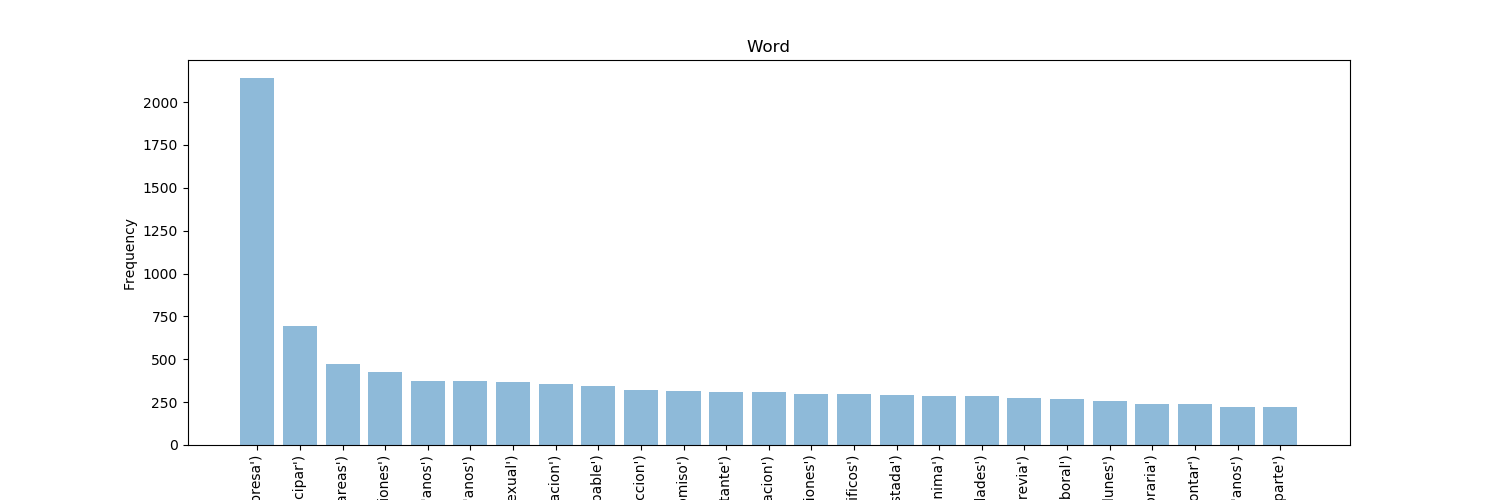

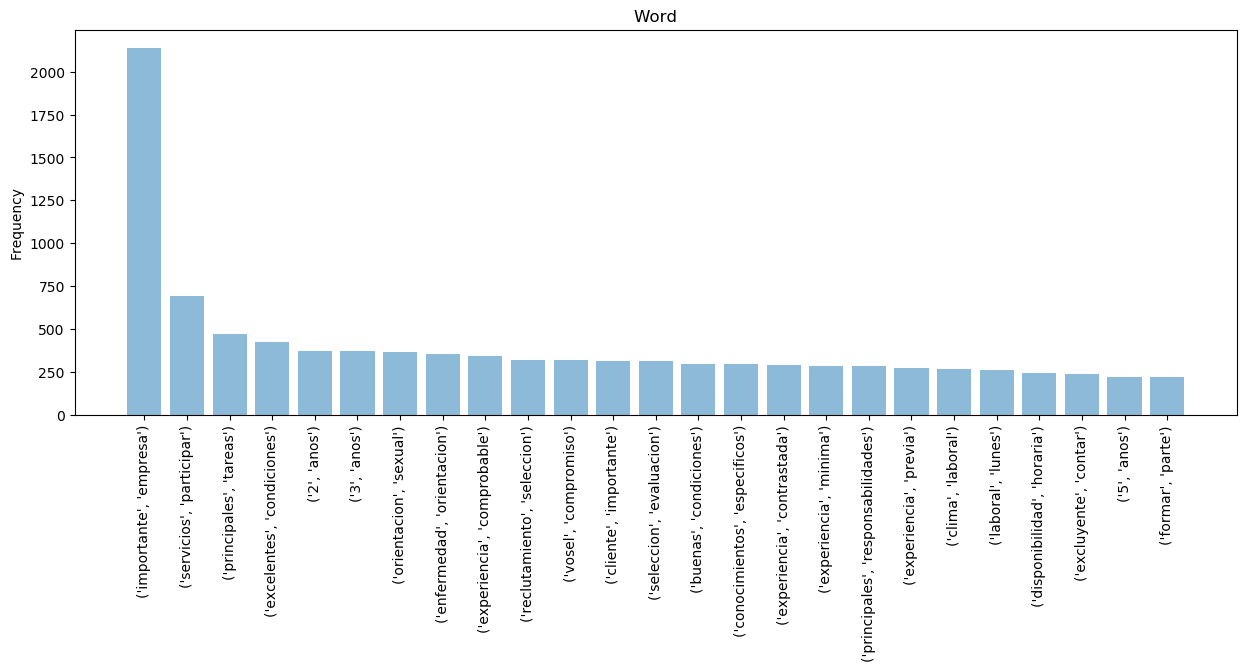

In [42]:
mas_usadas = sc.parallelize(mas_usadas)
mas_usadas = mas_usadas.map(lambda x: (x[0],0))
mas_usadas = mas_usadas.take(50)
lista = []
for x in mas_usadas:
    lista.append(x[0])
print(lista)
bigramsRDD = des.flatMap(lambda x: buscarBigramas(x,lista))
bigramsFreq = bigramsRDD.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y)
my_freqs = bigramsFreq.takeOrdered(25,lambda x:-x[1])
my_freqs
my_words = [i for i,j in my_freqs]
my_freqs = [j for i,j in my_freqs]

print(my_words)
print(my_freqs)

plt.close()
plt.clf()

fig, ax = plt.subplots()

y_pos = np.arange(len(my_words))
print(y_pos)
plt.bar(y_pos, my_freqs, alpha=0.5)
plt.ylabel('Frequency')
plt.title('Word')
ax.set_xticks(np.arange(0,25))
ax.set_xticklabels(my_words, rotation='vertical')
plt.savefig('foobar2.png')
Image("foobar2.png")

In [ ]:
trigramsRDD = des.flatMap(lambda x: buscarTrigramas(x,lista))
trigramsFreq = trigramsRDD.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y)
trigramsFreq.takeOrdered(25,lambda x:-x[1])

In [ ]:
bigramsRDD = des.flatMap(lambda x: buscarBigramas(x,['ingeniero','ingenieria','universitario','tecnico','tecnicatura','administrativo','secretario','secretaria','enfermero','enfermera','taxi','remis','remiseria','chofer','secundario', 'sabados','domingos','anos','experiencia', 'nivel','ingles']))
bigramsFreq = bigramsRDD.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y)
bigramsFreq.takeOrdered(25,lambda x:-x[1])

In [ ]:
trigramsRDD = des.flatMap(lambda x: buscarTrigramas(x,['ingeniero','ingenieria','universitario','tecnico','tecnicatura','administrativo','secretario','secretaria','enfermero','enfermera','taxi','remis','remiseria','chofer','secundario', 'sabados','domingos','anos','experiencia', 'nivel','ingles']))
trigramsFreq = trigramsRDD.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y)
trigramsFreq.takeOrdered(25,lambda x:-x[1])